# Self Organizing Map

### Can a Neural Network learn with unlabeled data? YOU BETCHA!

Unsupervised task with Neural Network

In [1]:
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
%matplotlib inline
plt.figure(figsize=(20,10));

## Read data

In [2]:
df = pd.read_csv('som_got_embedding_lookup.txt',header=-1,sep=' ')
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Columns: 301 entries, 0 to 300
dtypes: float64(300), object(1)
memory usage: 2.3+ MB


,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,Meera,-0.092121,0.104701,-0.041936,-0.006535,0.100802,-0.026256,-0.012895,0.055837,-0.012702,...,0.033146,0.041805,0.106177,-0.044814,0.043557,0.081989,-0.016194,0.042059,-0.053656,0.059873
1,days,-0.070485,-0.068735,-0.005541,0.008050,-0.025907,-0.056747,-0.025725,0.061224,0.050998,...,0.007330,0.034866,0.092918,0.090155,-0.022975,-0.028615,-0.001761,-0.096032,0.005933,-0.040342
2,cannot,0.051452,0.024792,0.042264,-0.093735,0.003651,-0.011852,0.000802,-0.089121,0.044036,...,-0.009870,-0.087178,0.061320,-0.028528,-0.013945,-0.053733,0.039426,0.031200,0.082319,0.059307


## Hyperparams

### X and Y size

Each **dot** represents a **neuron**, that has a specific position topologically => Bigger X/Y more neurons and viceversa. <br>
Each **neuron** contains/is **a vector of weights** of the **same dimension** of the **input vectors**.<br>
The **lines** connecting nodes just represent **adjacency**.<br>

<img style="width:300px"src="http://www.pitt.edu/~is2470pb/Spring05/FinalProjects/Group1a/tutorial/kohonen1.gif"><br>

## Dimensionality

It's just the size of the input vectors. In our case, we're using the output of Word2Vec (Word embeddings) with and embedding size of 300. This is, each word is represented with a 300 size vector.

I.e:<br>
[i1,i2,i3,...,i150,i151,...,i299,i1300] hi<br>
[0.1,-0.5,0.7,...,0.3,0.2,...,-0.1,0.9] hi

In [3]:
#Explained above, could be understood as the number of neurons in a 2D topological representation (200*200 = 4000 neurons)
x_size = 200
y_size = 200

#The size of the input vectors, in our case, our word embeddings of 300 size vectors.
dimensionality = 300

#Number of iterations of a NN as always
num_epochs = 10

## Model

## Attributes

### Weights

The matrix that joins each input vector with the 2D map of neurons.<br>

It's which will be trained, or in other words, updated in each step to provide a better final result.

Of course, the shape must be (x_size,y_size,dimensionality). One weight per neuron and per dimension.

Note: Because of our input vector are normalized the weights will be random initialized with values between [-1,1]

In [4]:
weights = np.random.uniform(low=-1.0, high=1.0, size=(x_size,y_size,dimensionality)).astype('float64')
weights.shape

(200, 200, 300)

### Map Radius

Just the radius of the map.

Take the biggest component of the shape and halve it.

In our case we have (200,200,300) so the biggest component is 300 and because of that the radius will be 150.

In [5]:
map_radius = max(weights.shape)/2
map_radius

150.0

### Const

A constant value that represent the **relation** between the **number of epochs** and the **map radius** (dimensionality of the map)

In [6]:
const = num_epochs/math.log(map_radius)
const

1.9957549119135505

## Functions

### Initialize Global Variables

In [7]:
def initialize_global_variables():
    weights = np.random.uniform(low=-1.0, high=1.0, size=(x_size,y_size,dimensionality)).astype('float64')
    map_radius = max(weights.shape)/2
    const = num_epochs/math.log(map_radius)

### Distance Matrix

Function used to compute the distance between the current weights and a vector.

**Cosine similarity** is used (instead of for example Euclidean Distance), this is because Word2Vec is our source <a href="https://www.reddit.com/r/MachineLearning/comments/493exs/why_do_they_use_cosine_distance_over_euclidean/">and...</a>

In [8]:
def distance_matrix(weights, vector):
    return np.dot(weights, vector)/(np.linalg.norm(weights)*np.linalg.norm(vector))

In [9]:
#Example
distance_matrix(weights=[[[0.2,0.5,0.7],[0.3,0.5,0.7],[-0.1,0.5,-0.8]]],vector=[0.1,0.3,0.9])

array([[ 0.52933722,  0.53595393, -0.38376948]])

### Best Match Unit - BMU

Function to compute the neuron which vector of weights it's the **most similar** to the input. This neuron is called the **Best match unit**

Uses: distance_matrix

In [10]:
def bmu(vector1, vector2):
    distance = distance_matrix(vector1,vector2)
    return np.unravel_index(distance.argmin(), distance.shape)

In [11]:
#Example
bmu(vector1=[[[0.2,0.5,0.7],[0.3,0.5,0.7],[-0.1,0.5,-0.8]]],vector2=[0.1,0.3,0.9])

#Output is 2 because the third component of the distance_matrix output vector (above) has the lowest value

(0, 2)

### BMU distance

Function to compute the actual distance of the BMU. 

With the oher function we know which neuron is the BMU, now we calculate the distance.

In [12]:
def bmu_distance(weights, vector):
    x, y, input_dim = weights.shape
    xi = np.arange(x).reshape(x, 1).repeat(y, 1)
    yi = np.arange(y).reshape(1, y).repeat(x, 0)
    return np.sum((np.dstack((xi, yi)) - np.array(bmu(weights,vector))) ** 2, 2)

In [13]:
#Example
bmu_distance(weights=np.array([[[0.2,0.5,0.7],[0.3,0.5,0.7],[-0.1,0.5,-0.8]]]),vector=[0.1,0.3,0.9])
#initialize_global_variables()
#bmu_distance(weights=weights,vector=df.iloc[0,1:])

array([[4, 1, 0]], dtype=int64)

### Hood radius

Compute the radius of the neighbourhood.

The radius will **decrease** as the **iterations** grows, as you can see in the example.

In [14]:
def hood_radius(const, iteration):
    return map_radius * math.exp(-iteration/const)

In [15]:
#Example
print(hood_radius(const,0),hood_radius(const,1),hood_radius(const,10),hood_radius(const,500),hood_radius(const,10000))

150.0 90.88289091276843 1.0000000000000002 2.35249281822594e-107 0.0


### teach_row

Where the real training is done.

The return of the function is the **update** of a row **row** of the weights.

In [16]:
def teach_row(weights, vector, iteration):
    #The hood radius 2 pow
    hood_radius_2 = hood_radius(const,iteration) ** 2
    #Compute the BMU distance
    bmu_dist = bmu_distance(weights,vector).astype('float64')
    #The update factor
    influence = np.exp(-bmu_dist / (2 * hood_radius_2))
    #The update
    return np.expand_dims(influence, 2) * (vector - weights)

In [17]:
#Example
teach_row(weights=np.array([[[0.2,0.5,0.7],[0.3,0.5,0.7],[-0.1,0.5,-0.8]]]),vector=[0.1,0.3,0.9],iteration=0)
#initialize_global_variables()
#teach_row(weights=weights,vector=df.iloc[0,1:].as_matrix(),iteration=0)

array([[[-0.09999111, -0.19998222,  0.19998222],
        [-0.19999556, -0.19999556,  0.19999556],
        [ 0.2       , -0.2       ,  1.7       ]]])

### Util function - Show

Just to show the result in a pretty way 

In [18]:
def show(weights):
    fig, ax = plt.subplots(figsize=(8, 8))
    show_weights = weights*256 #For RGB representation
    im = Image.fromarray(show_weights.astype('uint8'), mode='RGB')
    im.format = 'JPG'
    ax.imshow(np.asarray(im),aspect='auto')

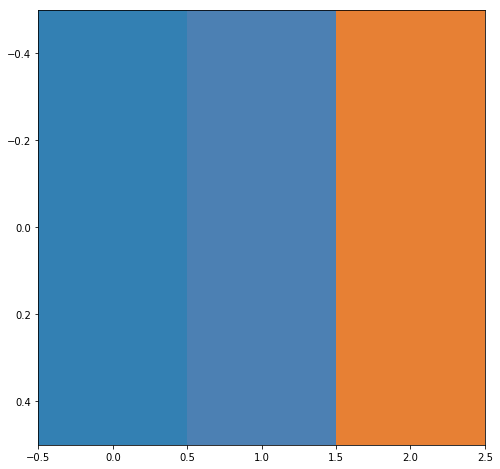

In [19]:
show(weights=np.array([[[0.2,0.5,0.7],[0.3,0.5,0.7],[-0.1,0.5,-0.8]]]))

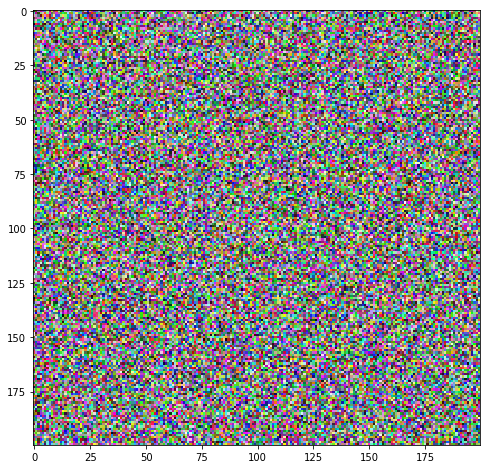

In [20]:
show(weights)

## Train

Let's train our Self Organizing Map!

Set train data

In [23]:
training_set = df.iloc[:,1:].as_matrix()
training_set.shape

(996, 300)

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9


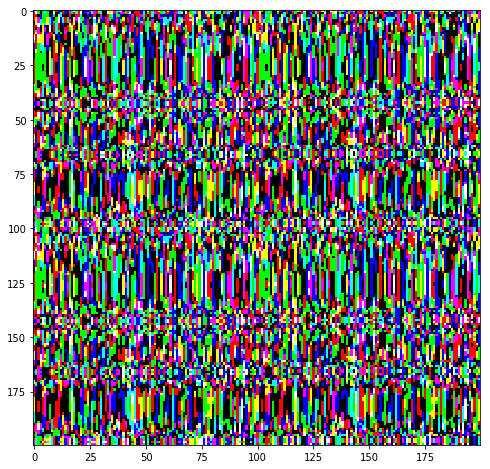

In [24]:
initialize_global_variables()
for epoch in range(num_epochs):
    print('Step %d' % epoch)
    for train_instance in training_set:
        update = teach_row(weights,train_instance, epoch)
        weights = weights + update

#Pretty show result
show(weights)

## References

<a href="https://www.youtube.com/watch?v=ov_RkIJptwE&ab_channel=SirajRaval">Siraj Raval - Youtube - Neural Networks - The Math of Intelligence #4</a><br>
<a href="http://www.pitt.edu/~is2470pb/Spring05/FinalProjects/Group1a/tutorial/som.html">Self Organizing Map Tutorial System - Pitt</a>